## Recognizing Styles of Brands and Products

'Style' data set by Olga Belitskaya on Kaggle.com on 8 March 2018; 
wget https://www.kaggle.com/olgabelitskaya/style-color-images/downloads/style-color-images.zip  
The codes and model here were developed on 30 June 2018.  

In [1]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline 

In [2]:
from fastai.imports import * 

In [3]:
from fastai.conv_learner import * 
from planet import f2 
from pathlib import Path 

### 1. Data 

In [4]:
PATH = Path("data/style/")
os.listdir(PATH)

['stylebrand.csv', 'styleproduct.csv', 'styletag.csv', 'train']

In [5]:
label_csv = f'{PATH}/styleproduct.csv'
n = len(list(open(label_csv)))-1 
val_idxs = get_cv_idxs(n) 
print('Total data:',n), print('Subset to validate:',len(val_idxs));

Total data: 894
Subset to validate: 178


In [6]:
label_df = pd.read_csv(label_csv) 
label_df.pivot_table(index='tag', 
                     aggfunc=len).sort_values('file', ascending=True)

,file
tag,
necklace,48
bracelet,49
boots,60
nail polish,61
earrings,63
lipstick,66
watches,78
ring,88
shoes,188


In [7]:
label_df.head()  #Sample of StyleProduct.csv 

,file,tag
0,0_0_001.png,shoes
1,0_0_002.png,shoes
2,0_0_003.png,shoes
3,0_0_004.png,shoes
4,0_0_005.png,shoes


((150, 150, 3), <matplotlib.image.AxesImage at 0x41b52e3be0>)

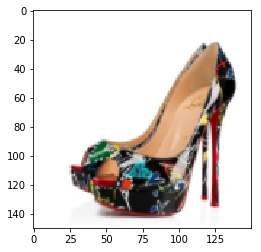

In [8]:
path2 = PATH/'train' 
img = open_image(path2/'0_0_001.png') 
img.shape, plt.imshow(img)

### 2.1 Simple Model 

In [9]:
sz = 96 #150 
bs = 4 
arch = resnet34 
mt = [f2]
tfms = tfms_from_model(arch, sz) 
md = ImageClassifierData.from_csv(PATH, 'train', 
                                  PATH/'styleproduct.csv', 
                                  tfms=tfms, val_idxs=val_idxs, bs=bs) 
learn = ConvLearner.pretrained(arch, md) 

In [10]:
learn.fit(0.01, 1) 

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.361968   0.198827   0.946374  



[array([0.19883]), 0.9463738508682328]

In [11]:
# Loss 19.8%  Accuracy 94.6%  size 96x96 
learn.summary()  

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 96, 96]),
                           ('output_shape', [-1, 64, 48, 48]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 48, 48]),
                           ('output_shape', [-1, 64, 48, 48]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 48, 48]),
                           ('output_shape', [-1, 64, 48, 48]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 48, 48]),
                           ('output_shape', [-1, 64, 24, 24]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 24, 24]),
        

### 2.2 Model  
Weight decay, Dropout, Differential learning rates

In [12]:
ps = [0.1, 0.1]
wd = 1e-7 
learn = ConvLearner.pretrained(arch, md, ps=ps) 
learn.opt_fn = optim.Adam 
learn.fit(0.01, 1, wds=wd) 

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.203217   0.13407    0.95097   



[array([0.13407]), 0.9509703779366702]

In [13]:
learn.unfreeze() 
learn.bn_freeze(True) 
lrs = np.array([1e-6, 1e-4, 1e-3]) 
learn.fit(lrs, 1) 

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.126623   0.104837   0.962206  



[array([0.10484]), 0.9622063329928497]

Loss 12.9%   Accuracy: 96.3% on size 96x96 ps 0.01, 0.01  
Loss 10.1%   Accuracy: 96.7% on size 96x96 ps 0, 0

In [14]:
learn.summary 

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

### 3.1 Multiple Classification: Data  

In [15]:
label_csv = f'{PATH}/styletag.csv'
n = len(list(open(label_csv)))-1 
val_idxs = get_cv_idxs(n) 
len(val_idxs) 

178

In [16]:
label_df = pd.read_csv(label_csv) 
label_df.pivot_table(index='tag', 
                     aggfunc=len).sort_values('file', ascending=True)

,file
tag,
Gucci nail polish,2
Gucci lipstick,2
Yves Saint Laurent bracelet,3
Dolce & Gabbana ring,3
Yves Saint Laurent ring,3
Yves Saint Laurent necklace,4
Dolce & Gabbana necklace,4
Dolce & Gabbana bracelet,4
Versace necklace,5


In [17]:
label_df.head()  #Sample of StyleTag.csv 

,file,tag
0,0_0_001.png,Christian Louboutin shoes
1,0_0_002.png,Christian Louboutin shoes
2,0_0_003.png,Christian Louboutin shoes
3,0_0_004.png,Christian Louboutin shoes
4,0_0_005.png,Christian Louboutin shoes


### 3.2 Multiple Classification  
Data augmentation, Model, Metric  

In [18]:
def g_md(sz=104, bs=4): 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, 
                           max_zoom=1.07)
    return ImageClassifierData.from_csv(PATH, 'train', 
                                        PATH/'styletag.csv', 
                                        tfms=tfms, 
                                        val_idxs=val_idxs, bs=bs)

In [19]:
wd = 1e-6 
ps = [0.3, 0.5] 
data = g_md(sz=104, bs=4)
lr = 1e-2 #0.01
learn = ConvLearner.pretrained(arch, data, ps=ps, metrics=mt)
learn.opt_fn = optim.Adam 
learn.fit(lr, 3, wds=wd)

epoch      trn_loss   val_loss   f2                                            
    0      0.360638   0.296841   0.578637  
    1      0.310818   0.305556   0.598648                                      
    2      0.294979   0.245424   0.667464                                      



[array([0.24542]), 0.6674636813542517]

Loss 29.5%  Accuracy 61.5% size 96x96 ps 0.2 0.5  
Loss 31.5%  Accuracy 56.3% size 96x96 ps 0.2 0.4 

In [20]:
wd = 1e-5 
lr2 = 3e-3 #0.003 
learn.fit(lr2, 3, wds=wd) 

epoch      trn_loss   val_loss   f2                                            
    0      0.262212   0.397737   0.700395  
    1      0.233797   0.278727   0.714411                                      
    2      0.242081   0.231698   0.693422                                      



[array([0.2317]), 0.6934222538001513]

Loss 23.1% Accuracy 68.8% size 104x104 ps 0.3 0.5 maxzoom 1.07 wd 1e-6  
Loss 24.5% Accuracy 66.7% size 104x104 ps 0.3 0.5 maxzoom 1.07 wd 1e-6 prior LR 0.01
Loss 23.3% Accuracy 69.3% size 104x104 ps 0.3 0.5 maxzoom 1.07 wd 1e-5 

In [21]:
wd = 1e-4 
lr3 = 2e-4 #0.0002 
learn.fit(lr3, 3, wds=wd) 

epoch      trn_loss   val_loss   f2                                            
    0      0.218068   0.286516   0.693881  
    1      0.210491   0.23056    0.695061                                      
    2      0.220133   0.218391   0.691324                                      



[array([0.21839]), 0.6913237292330251]

Loss 22.8% Accuracy 70.9% size 104x104 ps 0.3 0.5 maxzoom 1.07 wd 1e-6  
Loss 21.8% Accuracy 69.1% size 104x104 ps 0.3 0.5 maxzoom 1.07 wd 1e-4  

 76%|█████████████████████▎      | 136/179 [00:38<00:12,  3.57it/s, loss=0.891]

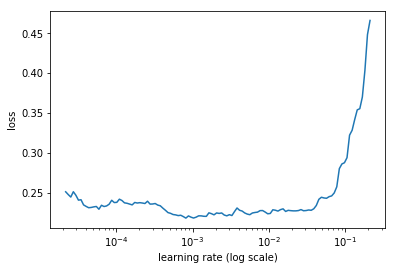

In [22]:
lrf = learn.lr_find() 
learn.sched.plot() 

In [23]:
lr4 = 5e-5 #0.00005 
lr2_5 = 6e-4 #6e-4 0.0006
lrs = np.array([lr4, lr3, lr2_5]) 
learn.unfreeze() 
learn.bn_freeze(True)
wd = 1e-5
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, wds=wd) 
learn.clip = lr 

epoch      trn_loss   val_loss   f2                                            
    0      0.288329   0.252504   0.648168  
    1      0.268026   0.227446   0.664236                                      
    2      0.188199   0.189654   0.755913                                      
    3      0.234941   0.227531   0.716712                                      
    4      0.175656   0.165677   0.801729                                      
    5      0.120874   0.137184   0.826785                                      
    6      0.080018   0.1287     0.831195                                      


[array([0.1287]), 0.8311948725818]

Loss 14.5% Accuracy 82.8% size 104x104 ps 0.3 0.5 wd 1e-5 unfreeze 

In [25]:
sz = 128 
learn.set_data(g_md(sz=sz, bs=4)) 
learn.opt_fn = optim.Adam 
learn.freeze() 
learn.fit(lr, 3, wds=wd) 

epoch      trn_loss   val_loss   f2                                            
    0      0.157394   0.217681   0.720864  
    1      0.1486     0.178388   0.788052                                      
    2      0.130794   0.190492   0.775008                                      


[array([0.19049]), 0.7750083888652317]

Loss 25.5% Accuracy 64.5% size 128x128 freeze  

In [26]:
learn.fit(lr2, 3, wds=1e-4) 

epoch      trn_loss   val_loss   f2                                            
    0      0.094403   0.14714    0.815588  
    1      0.08398    0.153315   0.805874                                      
    2      0.08689    0.152476   0.80566                                       


[array([0.15248]), 0.8056595640566312]

In [27]:
learn.fit(lr3, 3, wds=1e-4) 

epoch      trn_loss   val_loss   f2                                            
    0      0.074871   0.144086   0.812631  
    1      0.081613   0.14037    0.821803                                      
    2      0.080454   0.140183   0.823143                                      


[array([0.14018]), 0.8231429855342407]

In [28]:
learn.unfreeze() 
learn.bn_freeze(True) 
learn.fit(lrs, 3, wds=wd) 

epoch      trn_loss   val_loss   f2                                            
    0      0.223474   0.196942   0.750756  
    1      0.172296   0.200408   0.753058                                      
    2      0.143269   0.173939   0.762967                                      


[array([0.17394]), 0.7629665441093023]

In [29]:
lrs = np.array([lr4*.5, lr4, lr3]) 
learn.clip = lr  
learn.fit(lrs, 2, cycle_len=2, cycle_mult=2, wds=wd) 

epoch      trn_loss   val_loss   f2                                            
    0      0.071877   0.139611   0.833063  
    1      0.04193    0.129984   0.836032                                      
    2      0.059523   0.158869   0.810428                                      
    3      0.037385   0.143383   0.832632                                      
    4      0.028765   0.140019   0.83438                                       
    5      0.019841   0.141815   0.830316                                      


[array([0.14181]), 0.8303157017822518]

In [30]:
learn.save('128_styleMC')

In [33]:
data.val_y[:3]

array([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],
      dtype=float32)

In [34]:
data.classes

['&',
 'Chanel',
 'Christian',
 'Dior',
 'Dolce',
 'Gabbana',
 'Gucci',
 'Laurent',
 'Louboutin',
 'Saint',
 'Versace',
 'Yves',
 'boots',
 'bracelet',
 'earrings',
 'handbag',
 'lipstick',
 'nail',
 'necklace',
 'polish',
 'ring',
 'shoes',
 'watches']

In [35]:
multipreds, y = learn.TTA() 
preds = np.mean(multipreds, 0) 

In [36]:
f2(preds, y) 

0.8232399707262017

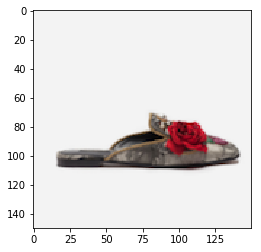

In [39]:
plt.imshow(open_image(path2/'2_0_028.png'))

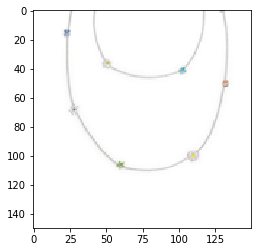

In [40]:
plt.imshow(open_image(path2/'4_4_008.png'))

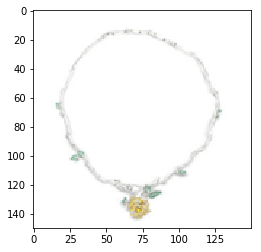

In [42]:
plt.imshow(open_image(path2/'4_4_006.png'))

This model using Resnet34 architecture achieved 83% accuracy in identifying branded accessories, jewelries and assorted products mainly because 22 categories have less than 10 image data to train the model. Furthermore, some of the images do not have distinct feature such as above, the item could be a ring, ear ring or necklace. Due to the lack of data, the accuracy may not be stable as the Test Time Augmentation yield 82% accuracy - Khoo KC. 30 June 2018. 

### End 

In [41]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),